# Data

> Code to generate dataloaders and datasets.


In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Optional, Any, Union, Iterable, List
from fastcore.utils import store_attr

import torch

/Volumes/Seagate2T/data1_files/kaggle_melanoma/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export
from PIL import Image
from fastcore.utils import Path

import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [ ]:
#|eval: false
workdir = Path('../input/')
tr_dir = workdir/'train'
img = None

if len(tr_dir.ls())>10:
    paths = tr_dir.ls()[:10]
else:
    paths = None

Dataset should get a list of paths and corresponding labels.


In [ ]:
# | export
class ClassificationDataset:
    def __init__(
        self,
        paths: List,
        labels: Optional[List] = None,
        augs: Optional[Any] = None,
    ):
        store_attr()

    def __getitem__(self, idx) -> Union[torch.Tensor, torch.Tensor]:
        path = self.paths[idx]
        # load image
        img = np.asarray(Image.open(path), dtype=np.float32)
        # apply aug
        if self.augs:
            img = self.augs(image=img)
            img = img["image"]
        # make tensor
        img = torch.FloatTensor(img).permute((2, 0, 1))
        # get labels if available
        if self.labels is not None:
            label = self.labels[idx]
            label = torch.LongTensor([label])
            return (img, label)
        return img

    def __len__(self) -> int:
        return len(self.paths)

    def show(self, idx):
        path = self.paths[idx]
        # load image
        img = np.asarray(Image.open(path), dtype=np.uint8)
        # apply aug
        if self.augs:
            img = self.augs(image=img)
            img = img["image"]
        return plt.imshow(img)


Testing if the dataset works as expected.


In [ ]:
#|eval: false
paths

(#10) [Path('../input/train/ISIC_0015719.jpg'),Path('../input/train/ISIC_0052212.jpg'),Path('../input/train/ISIC_0068279.jpg'),Path('../input/train/ISIC_0074268.jpg'),Path('../input/train/ISIC_0074311.jpg'),Path('../input/train/ISIC_0074542.jpg'),Path('../input/train/ISIC_0075663.jpg'),Path('../input/train/ISIC_0075914.jpg'),Path('../input/train/ISIC_0076262.jpg'),Path('../input/train/ISIC_0076545.jpg')]

In [ ]:
#|eval: false
fake_labels = np.random.choice([0, 1], size=10)
fake_labels

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [ ]:
#|eval: false
augs = A.Compose(
    [
        A.RandomBrightnessContrast(),
        A.Normalize(always_apply=True),
        A.Rotate(limit=45),
    ]
)


In [ ]:
#|eval: false
tr_dset = ClassificationDataset(paths=paths, labels=fake_labels, augs=augs)

In [ ]:
#|eval: false
img, label = tr_dset[0]
print(img.shape, label.shape)

torch.Size([3, 256, 256]) torch.Size([1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


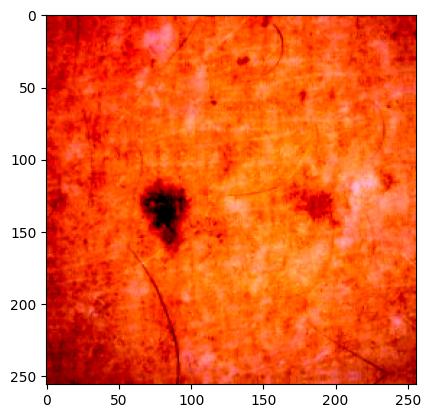

In [ ]:
#|eval: false
img = tr_dset.show(0)

Check if `DataLoader` works.


In [ ]:
#|eval: false
train_dl = DataLoader(tr_dset, batch_size=3, shuffle=True, drop_last=True)
for tb, (bi, bt) in enumerate(train_dl):
    print(tb, bi.shape)

0 torch.Size([3, 3, 256, 256])
1 torch.Size([3, 3, 256, 256])
2 torch.Size([3, 3, 256, 256])


# Lightning DataModule for Classification

As of Feb 23, 2023 Lightning Fabric is available that can do the same stuff as before but more control.


In [ ]:
#| export
from typing import Dict 
import pytorch_lightning as pl

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [ ]:
#| export
from melanoma import utils
import os

In [ ]:
#| export
NUM_WORKERS = os.cpu_count()

In [ ]:
#|eval: false
workdir = Path('../input/')

In [ ]:
# | export
class ClassificationDataModule(pl.LightningDataModule):
    def __init__(self, workdir, n_splits: int = 5, limit_samples: Optional = None):
        super().__init__()
        self.workdir = Path(workdir)
        self.n_splits = n_splits
        self.limit_samples = limit_samples

    def prepare_data(self):
        # download, tokenize, etc
        pass

    def setup(self, stage=None):
        # stage can be either 'fit', 'validate', 'test', or 'predict'
        # split, transform etc
        df = utils.create_folds(self.workdir, self.n_splits)
        # if testing, useful to avoid looping over entire dataset
        df = (
            df.sample(self.limit_samples, replace=False).reset_index(drop=True)
            if self.limit_samples is not None
            else df
        )
        # not K-fold for now
        tr_df = df.query("fold!=0").drop(columns=["fold"]).reset_index(drop=True)
        tr_paths = tr_df.image_name.apply(
            lambda x: self.workdir / f"train/{x}.jpg"
        ).to_list()
        tr_labels = tr_df.target.to_list()

        val_df = df.query("fold==0").drop(columns=["fold"]).reset_index(drop=True)
        val_paths = val_df.image_name.apply(
            lambda x: self.workdir / f"train/{x}.jpg"
        ).to_list()
        val_labels = val_df.target.to_list()

        tr_augs = A.Compose(
            [
                A.Normalize(always_apply=True),
                A.RandomBrightnessContrast(),
                A.Rotate(limit=45),
            ]
        )

        val_augs = A.Compose(
            [
                A.Normalize(always_apply=True),
            ]
        )

        self.tr_dset = ClassificationDataset(
            paths=tr_paths, labels=tr_labels, augs=tr_augs
        )

        self.val_dset = ClassificationDataset(
            paths=val_paths, labels=val_labels, augs=val_augs
        )

    def train_dataloader(self):
        return DataLoader(
            self.tr_dset,
            batch_size=32,
            num_workers=NUM_WORKERS,
            shuffle=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dset,
            batch_size=32,
            num_workers=NUM_WORKERS,
            shuffle=True,
            drop_last=True,
        )

    def test_dataloader(self):
        return None


Check if DataLoader works.


In [ ]:
#|eval: false 
dm = ClassificationDataModule('../input', limit_samples=300)

dm.setup()
len(dm.train_dataloader())

/Volumes/Seagate2T/data1_files/kaggle_melanoma/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Volumes/Seagate2T/data1_files/kaggle_melanoma/melanoma/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fold"].iloc[[val_idx]] = fold


7

# Setup model and training loop


In [ ]:
#|export 
from torchvision import models
from torch import nn
import torch.nn.functional as F

In [ ]:
#|eval: false
clf = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights)
clf.fc = nn.Linear(2048, 2)

/Volumes/Seagate2T/data1_files/kaggle_melanoma/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#|eval: false
x = torch.randn((3, 3, 256, 256))
y = torch.LongTensor([0, 1, 1])
clf(x), y.shape

(tensor([[-0.0715, -0.1679],
         [ 0.0807, -0.2785],
         [-0.0969,  0.1684]], grad_fn=<AddmmBackward0>),
 torch.Size([3]))

In [ ]:
#|eval: false
nn.CrossEntropyLoss()(clf(x), y)

tensor(0.7014, grad_fn=<NllLossBackward0>)

In [ ]:
#|eval: false
import pandas as pd
df = pd.read_csv(workdir/'train.csv')
df.target.value_counts()/df.shape[0]

0    0.98237
1    0.01763
Name: target, dtype: float64

In [ ]:
torch.vstack((torch.randn(3, 1), torch.randn(3, 1))).shape

torch.Size([6, 1])

In [ ]:
# | export
class ClassificationModel(pl.LightningModule):
    def __init__(self, model, loss_weights=None):
        super().__init__()
        self.model = model
        self.loss_weights = torch.Tensor(loss_weights)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        acts = self(x)  # batch_size, n_classes
        loss = nn.CrossEntropyLoss(weight=self.loss_weights)(acts, y.squeeze())
        probas = F.softmax(acts, -1)
        preds = probas.argmax(-1)
        return {
            "loss": loss,
            "train_preds": preds.squeeze().tolist(),
            "train_probas": probas[:, 1].detach().tolist(),
            "train_labels": y.squeeze().tolist(),
        }

    def validation_step(self, batch, batch_idx):
        x, y = batch
        acts = self(x)  # batch_size, n_classes
        loss = nn.CrossEntropyLoss(weight=self.loss_weights)(acts, y.squeeze())
        probas = F.softmax(acts, -1)
        preds = probas.argmax(-1)
        return {
            "valid_loss": loss,
            "valid_preds": preds.squeeze().tolist(),
            "valid_probas": probas[:, 1].detach().tolist(),
            "valid_labels": y.squeeze().tolist(),
        }

    def training_epoch_end(self, outputs):
        # outputs: a dict for each step
        if not self.trainer.sanity_checking:
            loss = np.array([x["loss"].item() for x in outputs]).mean()
            probas = np.array([x["train_probas"] for x in outputs]).reshape(-1)
            preds = np.array([x["train_preds"] for x in outputs]).reshape(-1)
            target = np.array([x["train_labels"] for x in outputs]).reshape(-1)
            self.log("train_loss", loss, on_step=False, on_epoch=True)
            self.log(
                "train_auc", roc_auc_score(target, probas), on_step=False, on_epoch=True
            )

    def validation_epoch_end(self, outputs):
        # outputs: a dict for each step
        if not self.trainer.sanity_checking:
            loss = np.array([x["valid_loss"].item() for x in outputs]).mean()
            probas = np.array([x["valid_probas"] for x in outputs]).reshape(-1)
            preds = np.array([x["valid_preds"] for x in outputs]).reshape(-1)
            target = np.array([x["valid_labels"] for x in outputs]).reshape(-1)
            self.log("valid_loss", loss, on_step=False, on_epoch=True)
            self.log(
                "valid_auc", roc_auc_score(target, probas), on_step=False, on_epoch=True
            )

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
# |eval: false
limit_samples = 300
max_epochs = 4
data = ClassificationDataModule("../input", limit_samples=limit_samples)
class_weights = [0.01763, 0.98237]  # inverse weights of class proba
model = ClassificationModel(clf, class_weights)

trainer = pl.Trainer(max_epochs=max_epochs, num_sanity_val_steps=0)
trainer.fit(model, data)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Volumes/Seagate2T/data1_files/kaggle_melanoma/.venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Volumes/Seagate2T/data1_files/kaggle_melanoma/melanoma/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["fold"].iloc[[val_idx]] = fold

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.0 M
---------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
91.936    Total estimated model params size (MB)
/Volumes/Seagate2T/data1_files

Epoch 3: 100%|██████████| 8/8 [02:54<00:00, 21.78s/it, loss=0.42, v_num=42] 

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 8/8 [02:57<00:00, 22.18s/it, loss=0.42, v_num=42]


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()